### Задача

- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# кастомизация графиков
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False, 
                 'figure.figsize': (10, 4)}
sns.set_theme(style = "ticks", rc = custom_params)

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

#### Группы 1 и 2

In [3]:
# вытащим данные из БД
query = '''
select 
    min(time) as time_var,
    user_id, exp_group,
    countIf(action, action = 'like') as likes,
    countIf(action, action = 'view') as views,
    likes / views as ctr
from simulator_20221020.feed_actions
where toDate(time)  >= '2022-10-03' and toDate(time) <= '2022-10-09' 
                                and exp_group in (1, 2)
group by user_id, exp_group
order by time_var desc
'''

df = pandahouse.read_clickhouse(query, connection = connection)

In [4]:
df.head(3)

,time_var,user_id,exp_group,likes,views,ctr
0,2022-10-09 23:59:47,141164,2,0,1,0.0
1,2022-10-09 23:59:30,17749,2,0,1,0.0
2,2022-10-09 23:59:03,115129,2,0,3,0.0


Проведем тесты на поюзерных CTR:

Text(0.6, 1.5, 'mann-whitney test: \nstatistic: 56601260.5 \np-value: 0.0')

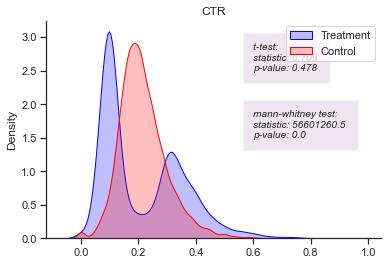

In [5]:
ttest_stat, ttest_pval = st.ttest_ind(df.query('exp_group == 1').ctr.values, df.query('exp_group == 2').ctr.values, equal_var = False)
mu_stat, mu_pval = st.mannwhitneyu(df.query('exp_group == 1').ctr.values, df.query('exp_group == 2').ctr.values)

sns.kdeplot(data = df, x = 'ctr', fill = True, hue = 'exp_group', palette = ['red', 'blue'])
plt.title('CTR')
plt.xlabel('')
plt.legend(['Treatment', 'Control'])
plt.text(0.6, 2.5, f'''t-test: \nstatistic: {round(ttest_stat, 3)} \np-value: {round(ttest_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})
plt.text(0.6, 1.5, f'''mann-whitney test: \nstatistic: {round(mu_stat, 3)} \np-value: {round(mu_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})

Т-тест различий в средних не видит, тест Мана-Уитни видит различия в распределениях.Посмотрим, что будет после линеаризации:

In [6]:
def linearization(treatment_likes, treatment_views, control_likes, control_views):
    
    '''
    Функция принимает на вход поюзерные лайки и просмотры для тестовой и контрольной групп, и распечатывает гистограмму с распределениями 
    линеаризованных лайков и результатами т-теста и теста Мана-Уитни.
    '''
    
    # Считаем общий CTR в контрольной группе
    global_ctr_control = control_likes.sum() / control_views.sum()
    
    # Посчитаем в обеих группах поюзерную метрику linearized_likes
    linearized_likes_treatment = treatment_likes - global_ctr_control * treatment_views
    linearized_likes_control = control_likes - global_ctr_control * control_views
    
    # сравним  тестами отличия в группах по метрике linearized_likes
    ttest_stat, ttest_pval = st.ttest_ind(linearized_likes_control, linearized_likes_treatment, equal_var=False)
    mu_stat, mu_pval = st.mannwhitneyu(linearized_likes_control, linearized_likes_treatment)
    
    # нарисуем
    sns.kdeplot(linearized_likes_treatment, fill = True)
    sns.kdeplot(linearized_likes_control, fill = True)
    plt.title('Linearized likes')
    plt.legend(['Treatment', 'Control'])
    plt.text(20, 0.09, f'''t-test: \nstatistic: {round(ttest_stat, 3)} \np-value: {round(ttest_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})
    plt.text(20, 0.05, f'''mann-whitney test: \nstatistic: {round(mu_stat, 3)} \np-value: {round(mu_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})

In [7]:
# вытащим данные для использования функции
treatment_likes = df.query('exp_group == 2').likes.values
treatment_views = df.query('exp_group == 2').views.values
control_likes = df.query('exp_group == 1').likes.values
control_views = df.query('exp_group == 1').views.values

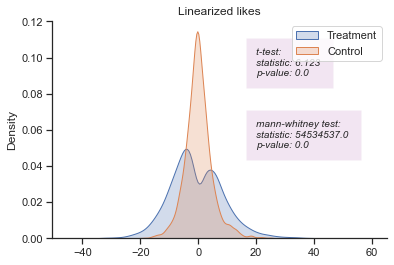

In [8]:
linearization(treatment_likes, treatment_views, control_likes, control_views)

Теперь т-тест видит различия в средних значениях, контрольная ветка работает лучше тестовой.

#### Группы 0 и 3

In [10]:
# вытащим данные из БД
query = '''
select 
    min(time) as time_var,
    user_id, exp_group,
    countIf(action, action = 'like') as likes,
    countIf(action, action = 'view') as views,
    likes / views as ctr
from simulator_20221020.feed_actions
where toDate(time)  >= '2022-10-03' and toDate(time) <= '2022-10-09' 
                                and exp_group in (0, 3)
group by user_id, exp_group
order by time_var desc
'''

df = pandahouse.read_clickhouse(query, connection = connection)

In [11]:
df.head(3)

,time_var,user_id,exp_group,likes,views,ctr
0,2022-10-09 23:59:56,126849,3,0,1,0.0
1,2022-10-09 23:59:35,34970,3,0,3,0.0
2,2022-10-09 23:59:24,35468,0,0,1,0.0


Проведем тесты на поюзерных CTR:

Text(0.5, 1.5, 'mann-whitney test: \nstatistic: 43682792.0 \np-value: 0.0')

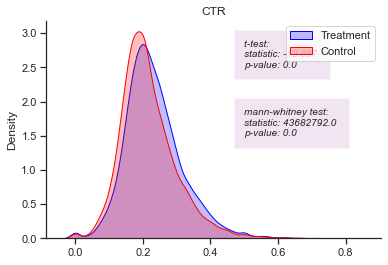

In [12]:
ttest_stat, ttest_pval = st.ttest_ind(df.query('exp_group == 0').ctr.values, df.query('exp_group == 3').ctr.values, equal_var = False)
mu_stat, mu_pval = st.mannwhitneyu(df.query('exp_group == 0').ctr.values, df.query('exp_group == 3').ctr.values)

sns.kdeplot(data = df, x = 'ctr', fill = True, hue = 'exp_group', palette = ['red', 'blue'])
plt.title('CTR')
plt.xlabel('')
plt.legend(['Treatment', 'Control'])
plt.text(0.5, 2.5, f'''t-test: \nstatistic: {round(ttest_stat, 3)} \np-value: {round(ttest_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})
plt.text(0.5, 1.5, f'''mann-whitney test: \nstatistic: {round(mu_stat, 3)} \np-value: {round(mu_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})

Т-тест видит различия в средних, тест Мана-Уитни различия в распределениях.

In [14]:
# вытащим данные для использования функции
treatment_likes = df.query('exp_group == 3').likes.values
treatment_views = df.query('exp_group == 3').views.values
control_likes = df.query('exp_group == 0').likes.values
control_views = df.query('exp_group == 0').views.values

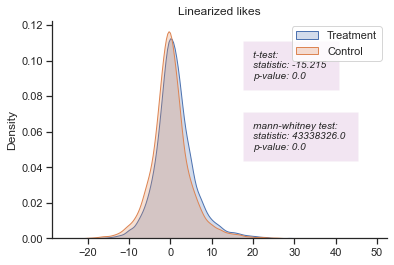

In [15]:
linearization(treatment_likes, treatment_views, control_likes, control_views)

 После т-теста значение статистики стало больше по модулю, значит p-value стал меньше - линеаризация работает.